# Project 3: Web APIs & NLP
## Reddit.com/r/workplacesitcoms 
#### By: Danielle Medellin [GitHub](https://github.com/dmedellin2)

## Table of Contents:
- [Problem Statement](#Problem-Statement)  
- [Executive Summary](#Executive-Summary)  
- [Data Import](#Data-Import)  
- [Data Cleaning](#Data-Cleaning)  
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Dummy Creation](#Creating-Dummies)
- [Model Preparation](#Model-Preparation)
- [Modeling](#Modeling)
    - [Baseline Model](#Baseline-Model)
    - [Linear Regression](#Linear-Regression)
    - [Ridge](#Ridge)
    - [Lasso](#Lasso)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
- [Using the Model](#Using-the-Model-to-Help-Joe)
- [Conclusions and Recommendations](#Conclusions-&-Recommendations)

## Problem Statement

NBC is looking to see how people on the internet engage with some of their most famous sitcoms. They assigned an intern to gather all the posts he could on reddit for the team to analyze later on. This intern is well.. an intern, and he just put all the posts into one folder! We were able to separate most posts, but the last two shows are still stuck together.. "The Office" and "Parks and Recreation." Given that they share some of the same creators, characterter names, and even actors (looking at you Rashida Jones..) our job is to build a model that is able to sort through these reddit posts and separate them back into their appropriate reddit threads: The Office -- r/DunderMifflin & Parks and Recreation -- r/PandR. 

On top of that, NBC is also interested in what content helped made it possible to differentiate between the two shows. We will build a classification model to help with this process and measure the success of the model through accuracy. 

## Executive Summary

Blah blah blahdhslkf

The data: 
What is the score?   https://www.reddit.com/wiki/faq#wiki_how_is_a_submission.27s_score_determined.3F

## Data Import
In the _data_gathering_ notebook, one can view the process for using the reddit API to collect posts from the r/DunderMifflin and r/PandR subreddits over the course of the past 10 years. Both subreddits were created in January of 2011.

### Importing Libraries

In [191]:
import pandas as pd
import numpy as pn
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.base import TransformerMixin
from sklearn.feature_selection import SelectKBest, chi2

import warnings
warnings.filterwarnings("ignore") 

In [5]:
reddit = pd.read_csv('../data/reddit.csv')

In [6]:
reddit.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Letter to Brendanawicz,This guy had no chance. He started out being c...,PandR,1571349530,RandySwango,4,18,True,2019-10-17
1,Just started watching the show on Amazon Prime...,At least on season two as I've noticed the sub...,PandR,1571352782,Oo00oOo00oOO,0,1,True,2019-10-17
2,Office Ladies podcast just came out to discuss...,NaN,PandR,1571353982,ImplicationOfDanger,6,11,True,2019-10-17
3,Noticed they didn't mention jerry in the S3 recap,The beginning of season 3 episode 1 has a reca...,PandR,1571367525,hogmanjr100,4,6,True,2019-10-17
4,Star trek movies rule,My favorite seasons are definitely 3/5/7. Seas...,PandR,1571407817,DEEP_HURTING,0,3,True,2019-10-18


## Data Cleaning

In [7]:
reddit.shape

(4675, 9)

In [8]:
reddit.isnull().sum()

title             0
selftext        570
subreddit         0
created_utc       0
author            0
num_comments      0
score             0
is_self           0
timestamp         0
dtype: int64

The only column with null values is the self text column, which we will likely not use in analysis. For text analysis, we will focus on the title column.

In [9]:
reddit.dtypes

title           object
selftext        object
subreddit       object
created_utc      int64
author          object
num_comments     int64
score            int64
is_self           bool
timestamp       object
dtype: object

In [10]:
reddit['subreddit'].value_counts()

DunderMifflin    2626
PandR            2049
Name: subreddit, dtype: int64

In [11]:
# casting subreddit as 0,1 0 = Office, 1 = P and R
reddit['subreddit'] = [1 if entry == 'PandR' else 0 for entry in reddit['subreddit']]

In [12]:
reddit['subreddit'].value_counts()

0    2626
1    2049
Name: subreddit, dtype: int64

In [13]:
# changing timestamp to a datetime object
reddit['timestamp'] = pd.to_datetime(reddit['timestamp'])

We created the `timestamp` column from the `created_utc` column so we won't need to use the `created_utc` column in our analysis.

In [14]:
reddit.dtypes

title                   object
selftext                object
subreddit                int64
created_utc              int64
author                  object
num_comments             int64
score                    int64
is_self                   bool
timestamp       datetime64[ns]
dtype: object

In [16]:
reddit.describe()

,subreddit,created_utc,num_comments,score
count,4675.000000,4.675000e+03,4675.000000,4675.000000
mean,0.438289,1.438933e+09,7.761711,17.507594
std,0.496230,7.384524e+07,21.852437,338.446323
min,0.000000,1.295128e+09,0.000000,0.000000
25%,0.000000,1.385971e+09,1.000000,1.000000
50%,0.000000,1.447577e+09,4.000000,4.000000
75%,1.000000,1.494051e+09,9.000000,10.000000
max,1.000000,1.572741e+09,1180.000000,22726.000000


In [116]:
reddit.groupby('subreddit').describe().T

subreddit                      0             1
created_utc  count  2.623000e+03  2.049000e+03
             mean   1.434901e+09  1.444052e+09
             std    7.362621e+07  7.385084e+07
             min    1.295128e+09  1.295516e+09
             25%    1.378064e+09  1.387495e+09
             50%    1.446944e+09  1.450752e+09
             75%    1.493682e+09  1.495985e+09
             max    1.571512e+09  1.572741e+09
num_comments count  2.623000e+03  2.049000e+03
             mean   8.550515e+00  6.092240e+00
             std    1.418975e+01  1.223009e+01
             min    0.000000e+00  0.000000e+00
             25%    2.000000e+00  1.000000e+00
             50%    5.000000e+00  3.000000e+00
             75%    1.000000e+01  7.000000e+00
             max    2.530000e+02  2.290000e+02
score        count  2.623000e+03  2.049000e+03
             mean   8.938620e+00  1.499122e+01
             std    2.109615e+01  5.506277e+01
             min    0.000000e+00  0.000000e+00
             25%    1.000000e+00  1.000000e+00
             50%    3.000000e+00  4.000000e+00
             75%    9.000000e+00  1.100000e+01
             max    4.300000e+02  1.105000e+03

In [31]:
reddit.sort_values('num_comments', ascending=False).head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
2373,The day they take The Office off of Netflix is...,NaN,0,1524740904,RonThunderfist,1180,22726,True,2018-04-26
4195,"SO9EO9 ""Dwight Christmas"" Episode Discussion","From Wikipedia: \n\n""When the party planning c...",0,1354841872,Prefer_an_astronaut,253,55,True,2012-12-06
4173,"SO9EO8 ""The Target"" Discussion Thread","From Wikipedia:\n\n""Angela goes to Dwight for ...",0,1354236859,Prefer_an_astronaut,236,56,True,2012-11-29
1521,"Parks And Recreation S06E08/09 ""Fluoride"" / ""T...",####Two new episodes again tonight! \n\n\n---\...,1,1385080735,atticus138,229,111,True,2013-11-21
863,Has anyone found another comedy that gives the...,The only one was the office. I felt attached t...,1,1465953727,andrew9360,210,185,True,2016-06-14


After exploring the data a bit, we see there is an outlier in the `num_comments` column. We will drop the row with 1180 comments.

In [32]:
reddit.drop([2373],inplace=True)

In [56]:
reddit.sort_values('score', ascending=False).head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
3605,Found the best way to watch The Office,First make sure you have enough time to watch ...,0,1416432589,Dan_Ashcroft,90,2540,True,2014-11-19
3083,"It is me, Rainn Wilson (that guy from The Offi...",At 1pm (PDT) I’ll be on the @SoulPancake snapc...,0,1463678376,IAmRainnWilson,105,2419,True,2016-05-19
1382,Why Jerry is without a doubt the best characte...,"lol jk, you're the worst Jerry!",1,1419978101,radslacker,100,1105,True,2014-12-30
769,"I can never, ever read ""treat yoself"" or ""trea...","And yes, I have treated myself more.",1,1482998253,geetannn,37,840,True,2016-12-29
964,"Just realized that Leslie, Ann, &amp; Tom all ...",I'm sure someone else has already pointed this...,1,1469893207,MooCow93,51,748,True,2016-07-30


After exploring the data a bit, we see there are some outliers in the `score` column. We will drop the rows with scores of more than 2000.

In [57]:
reddit = reddit[reddit['score']<2000]

In [168]:
count = 0
for i in range(len(reddit["title"])):
    try:
        if "Bird's" in reddit['title'][i]:
            count += 1
    except:
        pass
count

0

In [152]:
len(reddit["title"])

4672

## Exploratory Data Analysis

In [53]:
def new_boxplot(data,x,y,title,xlabel,ylabel,palette):
    plt.figure(figsize=(7,6))
    sns.boxplot(data=data, x=y, y=x, palette=palette)
    plt.title(title,size=15)
    plt.xlabel(xlabel,size=12)
    plt.ylabel(ylabel,size=12);

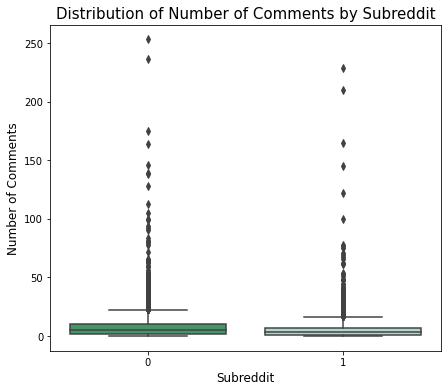

In [54]:
new_boxplot(reddit, 'num_comments','subreddit','Distribution of Number of Comments by Subreddit','Subreddit','Number of Comments','BuGn_r')

The majority of the data for both subreddits has less than 25 comments per post. The maximum amount of comments for both subreddits reaches around 230-250. Both subreddits have similar distributions, but the quartiles and maximum for the Office subreddit are generally higher than those of the Parks and Rec subreddit. Given the similarities in the distributions, it is unclear if the Number of Comments per post will be a helpful predictive feature in our model.

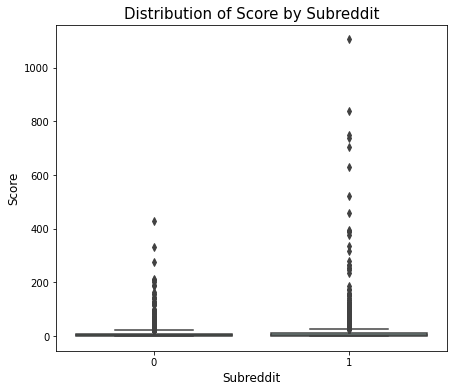

In [58]:
new_boxplot(reddit, 'score','subreddit','Distribution of Score by Subreddit','Subreddit','Score','BuGn_r')

The majority of the scores of posts for both subreddits is from 0-30. Both subreddits have scores that lay outside that range. The maximum for the Office subredit falling around 450, and the maximum for the Parks and Rec subreddit falling beyond 1000. There are many more posts with scores of 200 or more for the Parks and Rec subreddit as opposed to the Office subreddit. Looking at the Score for each post might be a helpful predictive feature in the model. 

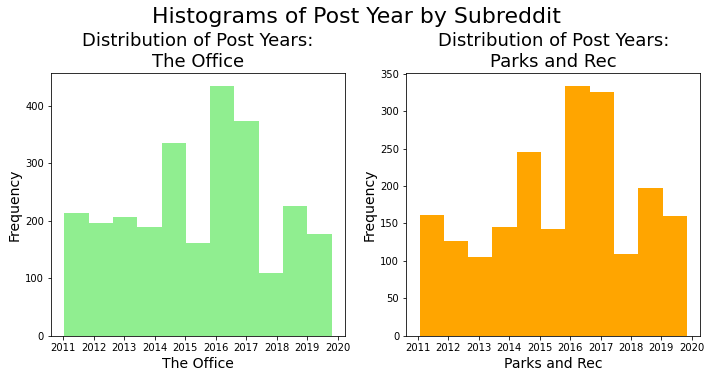

In [75]:
# pulling list of storage space types
cols = [0,1]

fig, axes = plt.subplots(figsize = (10,5), nrows = 1, ncols = 2)

fig.suptitle("Histograms of Post Year by Subreddit", fontsize = 22, y = 1.04) # y is percentage of figure height for placement

axes = axes.flatten()

color = ['lightgreen', 'orange']

for i, col in enumerate(cols):
    ax = axes[i]
    ax.hist(reddit[reddit['subreddit']==col]['timestamp'],color=color[i],bins=11)
    ax.set_ylabel("Frequency",size=14)
    readable_col = ['The Office','Parks and Rec']
    ax.set_xlabel(readable_col[i],size=14)
    ax.set_title(f"Distribution of Post Years:\n{readable_col[i]}",size=18)
    
plt.tight_layout();

We pulled data from every 6 months for the past 10 years. Both of these subreddits started in January of 2011. The two subreddits have similar distributions with peaks around 2016-2017. These are years that both of the shows were already off air. Neither subreddit seems to fall below 100 posts in a specific time range. Surprisingly, the most recent time range has a similar amount of posts as the first time range.

## Modeling

### Model Preparation

In [130]:
# setting X & y, train test split
#features = ['title','num_comments','score']
X = reddit['title']
y = reddit['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [128]:
X

,title,num_comments,score
0,Letter to Brendanawicz,4,18
1,Just started watching the show on Amazon Prime...,0,1
2,Office Ladies podcast just came out to discuss...,6,11
3,Noticed they didn't mention jerry in the S3 recap,4,6
4,Star trek movies rule,0,3
...,...,...,...
4670,Ultimate troll (X-post from f7u12),2,21
4671,Let's face it: The Office is over and peaked s...,2,0
4672,"Did anyone catch the Producer's Cut of the ""Go...",4,10
4673,Best Michael vs. Toby scene?,17,9


### Baseline Model

In [141]:
y_test.value_counts(normalize=True)

0    0.561644
1    0.438356
Name: subreddit, dtype: float64

Our baseline model would be one that predicts the majority class for every entry. If we did this, the model would perform with 56.1% accuracy, correctly predicting all of the entries from The Office subreddit (r/DunderMifflin). We are looking to make a model that performs better than the baseline.

### Natural Language Processing & Logistic Regression

In [202]:
# define pipeline
pipe = Pipeline([
    ('vec', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('selection', SelectKBest(chi2, k='all')),
    ('lr', LogisticRegression(solver='liblinear', C = 5))
])

# construct paramters
params = {'vec__max_features':[1000, 1500],
         'vec__ngram_range'  :[(1,1),(1,2),(2,2)],
         'vec__min_df'       :[1,2,3],
         'vec__max_df'       :[.90,.95],
          'tfidf__use_idf'   :[True,False],
         'lr__penalty'       :['l1','l2']}

 # Perform Grid Search
gs = GridSearchCV(pipe, # pipeline object replaces what we usually had as empty model class
                 param_grid=params,
                 cv = 4,
                 scoring = 'accuracy')
results = gs.fit(X_train, y_train)

In [203]:
results.best_score_

0.7985159817351598

In [204]:
results.best_params_

{'lr__penalty': 'l2',
 'tfidf__use_idf': False,
 'vec__max_df': 0.9,
 'vec__max_features': 1500,
 'vec__min_df': 1,
 'vec__ngram_range': (1, 1)}

In [205]:
results.score(X_test, y_test)

0.7970890410958904

In [206]:
pvalues = results.best_estimator_.steps[2][1].pvalues_

117

In [213]:
coefs = results.best_estimator_.steps[3][1].coef_

In [ ]:
results.best_estimator_.steps[3][1].

In [224]:
cols = list(results.best_estimator_.steps[0][1].vocabulary_.keys())

In [228]:
cols = pd.Series(cols)

In [230]:
cols.shape

(1500,)

In [235]:
coefs = coefs[0]

In [238]:
feature_coefs = pd.DataFrame(coefs, cols)

In [247]:
feature_coefs.sort_values(0,ascending=False).head(15)

,0
sounds,7.021776
hours,6.465917
really,6.358211
named,6.268100
actually,5.647281
predicted,5.636005
christmas,5.392271
didn,5.150197
stop,4.972197
000,4.753421


In [212]:
n_grams = results.best_estimator_.steps[0][1].get_feature_names()

['000',
 '10',
 '100',
 '1080p',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '2011',
 '2013',
 '2015',
 '2016',
 '2017',
 '21',
 '22',
 '2nd',
 '30',
 '3rd',
 '48',
 '50',
 'able',
 'abraham',
 'absolute',
 'absolutely',
 'accent',
 'accepted',
 'accountant',
 'accounting',
 'act',
 'acting',
 'actor',
 'actors',
 'actress',
 'actual',
 'actually',
 'ad',
 'adam',
 'add',
 'added',
 'addicted',
 'adding',
 'addition',
 'admit',
 'admitted',
 'advice',
 'affair',
 'ago',
 'agree',
 'ahead',
 'air',
 'aired',
 'airing',
 'aj',
 'aka',
 'album',
 'alert',
 'alfredo',
 'alliance',
 'allowed',
 'ama',
 'amazing',
 'america',
 'american',
 'americans',
 'amp',
 'amy',
 'andy',
 'angela',
 'animal',
 'ann',
 'anne',
 'announcement',
 'announcers',
 'annoying',
 'ansari',
 'answer',
 'answers',
 'anybody',
 'anymore',
 'apparently',
 'appear',
 'appearance',
 'appears',
 'appreciate',
 'appreciated',
 'appreciation',
 'april',
 'arc',
 'area',
 'arnett',
 'arrested',

In [92]:
results.best_estimator_.steps[0][1].get_feature_names()

['10',
 '12',
 '13',
 '30',
 'accent',
 'actually',
 'adam',
 'ago',
 'ama',
 'amazing',
 'america',
 'american',
 'amp',
 'amy',
 'andy',
 'angela',
 'ann',
 'anybody',
 'april',
 'ask',
 'asked',
 'asking',
 'attention',
 'aubrey',
 'awesome',
 'baby',
 'bad',
 'based',
 'believe',
 'ben',
 'best',
 'better',
 'big',
 'binge',
 'birthday',
 'bit',
 'black',
 'bloopers',
 'book',
 'boss',
 'box',
 'branch',
 'break',
 'business',
 'buy',
 'california',
 'called',
 'came',
 'campaign',
 'car',
 'carell',
 'casino',
 'cast',
 'catch',
 'caught',
 'change',
 'changed',
 'changes',
 'character',
 'characters',
 'charles',
 'choose',
 'chris',
 'christmas',
 'city',
 'clip',
 'cold',
 'com',
 'come',
 'comedy',
 'coming',
 'connection',
 'content',
 'continuity',
 'cool',
 'costume',
 'couldn',
 'councilman',
 'crazy',
 'credits',
 'creed',
 'crew',
 'cringe',
 'cut',
 'dae',
 'damn',
 'darryl',
 'date',
 'dated',
 'david',
 'day',
 'days',
 'deleted',
 'did',
 'didn',
 'different',
 'disa

In [108]:
model = results.best_estimator_

In [110]:
model.score(X_test, y_test)

0.7902397260273972

### References

https://www.reddit.com/r/DunderMifflin/  
https://www.reddit.com/r/PandR/